### Homework 6: AirBnB Clustering and PCA
#### Author: Ceyda Durmaz
#### Date: 12/16/2020
##### Link to GitHub repository: https://github.com/cdurmaz569/Data_Science_I_Homework/tree/master/Homework_6

In [1]:
# Import packages 
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
import sidetable

# Set options
plt.style.use('seaborn-ticks')
sns.set_style("ticks")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

### Abstract
Airbnb has thousands of listings in Istanbul that can take time for prospective guests to examine. Using PCA and K-Means Clustering, listings can be grouped into clusters of listings that similar by a set of 18 selected features. Features pertain to listing offerings and listing types. This clustering enables a quicker viewing of listings siimilar in many features, such as pricing, property type, and room type. These results establish that a subset of listings in the top five most visited neighbourhoods in Istanbul can be clustered together. 


### Introduction
The city of Istanbul, Turkey consistently places within the top ten most visited cities in the world. In 2019, Istanbul was the 8th most visited city globally (source: https://www.businessinsider.com/most-visited-cities-around-the-world-ranked-2019-9). Given its popularity, at the end of 2019, there were 21,970 Airbnb listings throughout Istanbul. For potential visitors, it can be a daunting task to investigate each listing, especially due to the vast size of the city and the density of listings in each neighborhood. 

One way to decrease the time prospective visitors spend examining each listing and it's offerings to try and group listings based on a set of features. This could be accomplished by reducing those many feaetures one may require of a listing down to principal components and visualizing the clusters of those principal components using k-menas clustering. 

### Methods
##### Data
Data was obtained from the Inside Airbnb website (http://insideairbnb.com/get-the-data.html). This specific dataset is a csv that contains listing information for Istanbul, Turkey untul December 31, 2019. The detailed listing containted information for 21,970 Airbnb listings and each listing had 106 associated features providing information on various aspects of the listing. 

##### Data Cleanup and Preprocessing
Data was first filtered by columns to retain only relevant columns. Columns filtered pertained to urls, lengthy description difficult to quantify, address information, and redudancy. Columns were also discarded if more than 20% of entries were missing. Columns of object type were dummy encoded and converted to categorical types for downstream encoding. 
Upon examining the data, there was an excess in types of properties. To simplify interpretation, data was subset to retain only the top 3 listing property types: apartment, serviced apartment, and house. To further ease analysis, the top five neighbourhood with the most listings were selected for downstream focus. 

Within the subsetted data, column entries were cleaned. Existing entries with 'NA' were replaced with placeholders. In columns with text entry types, missing entries were simply replaced with an empty string. Columns with categorical entry types had missing entries replaced with mode and columns with float types had missing entries replaced with the median. Entry replacement for categorical and float type columns were performed using SimpleImputer. The 'price' and 'extra_people' columns were also reformated to float type. Categorical column entries were one-hot encoded into numerical form and the dataset was filtered to retain only numeric features for downstream analysis. Lastly the data was checked for columns with outliers to remove. After investigating each outlier, an adjusted price column was created to correct for prices entered for minimum number of nights opposed to per night. Price categories were also obtained: low prices (less than 50), medium prices (between 50-200), and high prices (more than 200). 

Features were then selected for unsupervised learning. A total of 18 features were kept. Features retained related to listing offerings relevant to a prospective traveler's lodging preferences. Critical features included 'bathrooms', 'bedrooms', 'beds', and 'bed_types'. Other features included specification about the listing itself, such as 'property_type' and 'room_type'.  

The data were then scaled so that the new values have a standard deviation from the mean equivalent to one. Thus, the resulting scaled data will have have a new range of values, but maintain the shape of the original distribution. Scaling is important for downstream analysis becuase if the data are not scaled, explained variance can be attributed to features with larger values. To scale, StandardScaler was used. StandardScaler standardize a feature by subtracting the mean and then scaling to unit variance by dividing all values by the standard deviation. The resulting scaled data will have a mean near '0' and a variance of '1'. 

##### Principal Component Analysis
To properly explore and visualize the 18 selected features, principal component analysis (PCA) was performed. PCA is a linear feature extraction technique that reduces the dimensionality of the data so the variance of the data in the lower-dimensional space is maximized and output as a smaller feature set. 

From a covariance matrix, eigenvectors, or principal components, are calculated. The principal components represent weighted, linear combinations of features that are designed to be linearly independent and account for the largest possible variability in the data. From the principal components, a significant fraction of the variance of the data can be reconstructed. This is important in visualizing and exploring the data because the least important features can be discarded from consideration. 

##### K-Means Clustering
From the generated PCA visualization of the data, K-Means clustering can be employed to group the listings into clusters. The resulting clusters will be an aggregated group of similar listings. By clustering the data, it is possible to investigate it for any existing patterns. 

The K-Means clustering method will look for pre-defined K clusters. The K value was chosen using an elbow plot, where the number of clusters is plotted against the sum of squared distances from each listing entry to their cluster center. The algorithm begins by randomly selecting allocated centroids, or starting positions for each cluster, before iteratively calculating the optimal centroid position. When none of the centroids alter its value in the re-calculation, the centroids are deemed centered in the middle of its cluster. 


In [2]:
# Function - Get columns with NA entries
def getColsNA(df): 
    na_stats = df.isnull().sum().to_frame()
    na_stats.columns = ['num_na']
    na_stats['pct_na'] = np.round(100 * (na_stats['num_na'] / df.shape[0]))
    na_stats.sort_values(by='num_na', ascending=False, inplace=True)
    return na_stats

# Function - Replace NA vals based on col object type
def replaceNA(cols, df):
    for c in cols:
        if type(df[c].dtype) is pd.core.dtypes.dtypes.CategoricalDtype:
            mode_imputer = SimpleImputer(strategy='most_frequent')
            df.loc[:, c] = mode_imputer.fit_transform(df[[c]])
        elif df[c].dtype == 'float64' or df[c].dtype == 'int64':
            median_imputer = SimpleImputer(strategy='median')
            df.loc[:, c] = median_imputer.fit_transform(df[[c]])
        else:
            raise ValueError("Invalid column type")
    return df

# Function - Get outlier counts
def numberOfOutliers(mySeries, upperOutlier, lowerOutlier):
    return sum((mySeries > upperOutlier.loc[mySeries.name, ]) |\
               (mySeries < lowerOutlier.loc[mySeries.name,]))

# Function - Return df with stats of outliers 
def outlierStats(df):
    numericDescribe = (df.describe(include='all').T).round(decimals=3)
    
    # Calculate outliers 
    numericDescribe['IQR'] = numericDescribe['75%'] - numericDescribe['25%']
    numericDescribe['outliers'] = (numericDescribe['max'] > (numericDescribe['75%'] + (1.5 * numericDescribe['IQR']))) \
                            | (numericDescribe['min'] < (numericDescribe['25%'] - (1.5 * numericDescribe['IQR'])))
    
    # Calculate IQR 
    IQR = df.quantile(.75) - df.quantile(.25)
    
    # Calculate the upper and lower outlier values
    upperOutlier = df.quantile(.75) + (1.5 * (IQR))
    lowerOutlier = df.quantile(.25) - (1.5 * (IQR))
    
    # Save output as new cols
    numericDescribe['num_outliers'] = df.apply(numberOfOutliers, args=(upperOutlier, lowerOutlier))
    numericDescribe.sort_values('num_outliers', ascending=False, inplace=True)
    newColOrder = ['count', 'outliers', 'num_outliers', 'IQR', 'mean', 'std', \
               'min', '25%', '50%', '75%', 'max']
    numericDescribe = numericDescribe.reindex(columns=newColOrder)
    return numericDescribe

# Load listings data
listings = pd.read_csv('listings.csv', low_memory = False)

# Drop irrelevant columns
listings.columns
drop_cols = ['listing_url','last_scraped','experiences_offered',
             'picture_url','host_url','host_name',
             'host_since','host_location','host_about',
             'host_thumbnail_url','host_picture_url','host_neighbourhood',
             'street','neighbourhood','city',
             'state','zipcode','market',
             'smart_location','country_code','country',
             'calendar_updated','calendar_last_scraped','first_review',
             'last_review','thumbnail_url','medium_url','xl_picture_url',
             'minimum_nights_avg_ntm','maximum_nights_avg_ntm',
             'scrape_id','host_id','minimum_minimum_nights',
             'maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights']
listings = listings.drop(columns = drop_cols)
             
# Drop cols with more than 20% of NA entries
empty_cols = getColsNA(listings)
drop_cols = list(empty_cols[empty_cols.pct_na > 20].index)
listings = listings.drop(drop_cols, axis='columns')

# Get dummy variables for encoding
listings.select_dtypes(['object']).head()
cat_cols = ['host_is_superhost','host_has_profile_pic','host_identity_verified',
            'is_location_exact','property_type','room_type',
            'bed_type','has_availability','requires_license',
            'instant_bookable','is_business_travel_ready','cancellation_policy',
            'require_guest_profile_picture','require_guest_phone_verification']

# Set dummy cols from object to categories
listings[cat_cols] = listings[cat_cols].apply(lambda x: x.astype('category'),axis='rows')

# Get count of uniq vals for each lab
cnt_uniq = listings[cat_cols].apply(pd.Series.nunique, axis='rows')
#print(cnt_uniq)

# Too many property types, check why
#listings.property_type.value_counts()

# Subset data to include only top 3 properties
df_airbnb = listings[listings.property_type.isin(['Apartment', 'Serviced apartment', 'House'])]

# Get top 5 neighborhoods with most listings
df_airbnb.neighbourhood_cleansed.value_counts()
top5 = df_airbnb.groupby("neighbourhood_cleansed").count()
top5 = top5.sort_values(by = ["id"], ascending=False)
top5 = list(top5.head().index)
df_airbnb = df_airbnb[df_airbnb.neighbourhood_cleansed.isin(top5)]

# Explicitly remove the unused categories.
df_airbnb = df_airbnb.copy()
df_airbnb.loc[:, 'property_type'] = df_airbnb.loc[:,'property_type'].cat.remove_unused_categories()
df_airbnb.property_type.value_counts()

# Examine NA in dataset
df_na = getColsNA(df_airbnb)

# Collect all the columns which have missing values
cols_na = list(df_na[df_na.num_na > 0].index)
df_airbnb_na = df_airbnb[cols_na]
#df_airbnb_na.info()

# Handle Missing Values
df_airbnb_clean = df_airbnb.copy(deep=True)
df_airbnb_clean.shape

# Replace object columns' NA with empty string
df_airbnb_clean.loc[df_airbnb_clean.summary.isna().copy(), 'summary'] = ''
df_airbnb_clean.loc[df_airbnb_clean.description.isna().copy(), 'description'] = ''
df_airbnb_clean.loc[df_airbnb_clean.name.isna().copy(), 'name'] = ''

# Replace categorical columns' NA with mode
# Replace float columns' NA with median
cat_na = ['host_has_profile_pic', 'host_identity_verified',
          'host_is_superhost',]
float_na = ['bathrooms', 'beds', 'bedrooms',
            'host_total_listings_count',
            'host_listings_count']
df_airbnb_clean = replaceNA(float_na, df_airbnb_clean)
df_airbnb_clean = replaceNA(cat_na, df_airbnb_clean)

# Clean price and extra_people
df_airbnb_clean['price'] = df_airbnb_clean.price.apply(lambda x:re.sub(r'[$,]', '', x)).astype('float')
df_airbnb_clean['extra_people'] = df_airbnb_clean.extra_people.apply(lambda x:re.sub(r'[$,]', '', x)).astype('float')

# One-hot encode categorical variables
category_one_hot_encoding = pd.get_dummies(df_airbnb_clean[cat_cols])
#category_one_hot_encoding.head()
#category_one_hot_encoding.shape

# Get labels
labs_neig = pd.DataFrame(df_airbnb_clean.neighbourhood_cleansed)
labs_prop = pd.DataFrame(df_airbnb_clean.property_type)
labs_room = pd.DataFrame(df_airbnb_clean.room_type)

# Merge data and drop categorical variables
df_airbnb_clean = pd.concat([df_airbnb_clean, category_one_hot_encoding],
                            axis='columns').drop(cat_cols, axis='columns')

# Isolate numeric features from text/cat features + unnecessary cols
drop_cols = list(df_airbnb_clean.select_dtypes(['O']).columns) + ['id', 'latitude', 'longitude', 'maximum_nights']
df_airbnb_clean.drop(drop_cols, axis=1, inplace=True)

# Convert all cols to float
df_airbnb_clean = df_airbnb_clean.astype(float)

# Examine outliers
outlier_stats_df = outlierStats(df_airbnb_clean)

# Create price category and handle price outliers
df_airbnb_clean['price_adjusted'] = df_airbnb_clean['price'] / df_airbnb_clean['minimum_nights']
df_airbnb_clean.drop(['price', 'minimum_nights'], axis='columns', inplace=True)
drop_more_cols = ['host_total_listings_count',
                  'host_listings_count',
                 'host_total_listings_count',
                 'calculated_host_listings_count_entire_homes',
                 'calculated_host_listings_count_private_rooms',
                 'availability_365']
df_airbnb_clean.drop(drop_more_cols, axis=1, inplace=True)
#outlierStats(df_airbnb_clean)

# Create price category 
df = df_airbnb_clean.copy()
lo_idx = df[df.price_adjusted < 50].index
mid_idx = df[(df.price_adjusted >= 50) & (df.price_adjusted < 200)].index
hi_idx = df[df.price_adjusted >= 200].index

# Create new col for price category
df.loc[lo_idx, 'price_category'] = 'low'
df.loc[mid_idx, 'price_category'] = 'medium'
df.loc[hi_idx, 'price_category'] = 'high'
labs_price = pd.DataFrame(df.price_category)

# Drop price category 
df.drop(columns=['price_category'])

# Select features 
col_feat = ['bathrooms', 'bedrooms', 'beds', 
            'property_type_Apartment', 'property_type_House', 
            'property_type_Serviced apartment', 
            'room_type_Entire home/apt', 'room_type_Hotel room', 
            'room_type_Private room', 'room_type_Shared room',
            'bed_type_Airbed', 'bed_type_Couch', 'bed_type_Futon', 
            'bed_type_Pull-out Sofa', 'bed_type_Real Bed', 
            'price_adjusted', 'guests_included', 'accommodates']
df = df[col_feat]

# Scale data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

# Create PCA instance
pca = PCA()
pca.fit(scaled_df)
features = range(pca.n_components_)
pca_features = pca.transform(scaled_df)
pca_df = pd.DataFrame(pca_features)

# Collapse dimmensionality
pca_scores = pca.fit_transform(scaled_df)

# Get K-meanas for K=1 to K=20 clusters
inertias = {}
for k in range(1,21):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(pca_df)
    inertias[k] = kmeans.inertia_
    
# KMeans for 10 clusters
kmeans10 = KMeans(n_clusters=10)
kmeans10.fit(pca_scores)
y_kmeans10 = kmeans10.predict(pca_scores)


### Results

##### Principal Component Analysis
The first step of PCA is to reduce the number of features within the dataset. Using sklearn's PCA implementation, 18 principal components were obtained. Each principal component was visualized by how much variance each captured (Figure 1, top left). The bar plot shows that the first four principal components explain the majroity of the variance in the data, as seen by the variance drop-off after 'PC 2', the third component.

Scatter plots were used to visualize different sets of components: PC1 vs PC2, PC1 vs PC3, and PC2 vs PC3 (Figure 1). The scatter plots show that listings can be grouped into different sets of listings based on some of the selected features. 


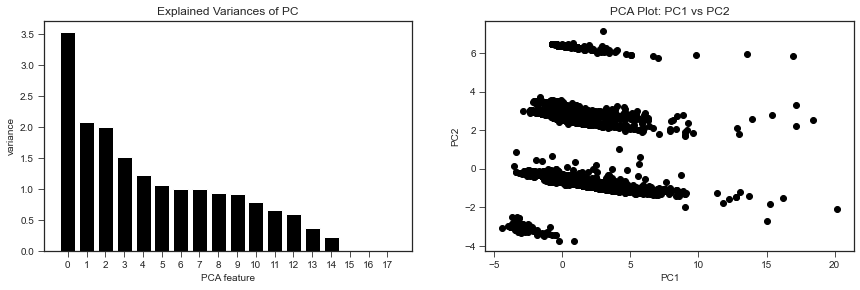

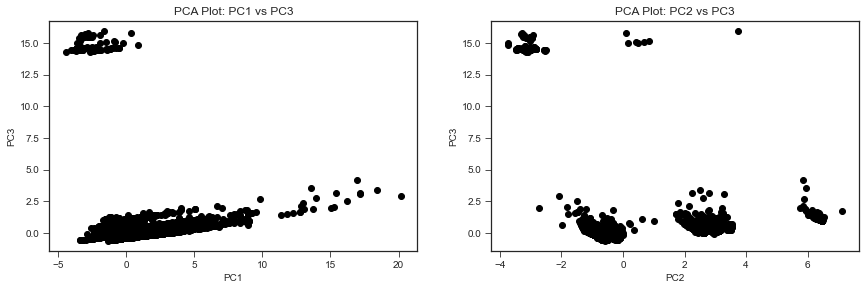

Figure 1. Top left shows scree plot of PC components. Top right shows scatter plot of first two components. Bottom left shows scatter plot of first and third component. Bottom right shows scatter plot of second and third component.


In [3]:
# Plot explained variances
plt.subplot(1, 2, 1)
plt.bar(features, pca.explained_variance_, color='black')
plt.xticks(features)
plt.ylabel('variance')
plt.xlabel('PCA feature')
plt.title("Explained Variances of PC")

# Plot scores on first versus second PC
plt.subplot(1, 2, 2)
plt.scatter(pca_scores[:,0], pca_scores[:,1], color='black'); 
plt.xlabel("PC1");
plt.ylabel("PC2");
plt.title("PCA Plot: PC1 vs PC2")

plt.subplots_adjust(left  = 0.125,   # the left side of the subplots of the figure
                right = 2.0,     # the right side of the subplots of the figure
                bottom = 0.1,    # the bottom of the subplots of the figure
                top = 0.9,       # the top of the subplots of the figure
                wspace = 0.2,    # the amount of width reserved for blank space between subplots
                hspace = 0.2)   # the amount of height reserved for white space between subplots

plt.show()

# Plot scores on first versus third PC
plt.subplot(1, 2, 1)
plt.scatter(pca_scores[:,0], pca_scores[:,2], color='black'); 
plt.xlabel("PC1");
plt.ylabel("PC3");
plt.title("PCA Plot: PC1 vs PC3")

# Plot scores on first versus fourth PC
plt.subplot(1, 2, 2)
plt.scatter(pca_scores[:,1], pca_scores[:,2], color='black'); 
plt.xlabel("PC2");
plt.ylabel("PC3");
plt.title("PCA Plot: PC2 vs PC3")

plt.subplots_adjust(left  = 0.125,   # the left side of the subplots of the figure
                right = 2.0,     # the right side of the subplots of the figure
                bottom = 0.1,    # the bottom of the subplots of the figure
                top = 0.9,       # the top of the subplots of the figure
                wspace = 0.2,    # the amount of width reserved for blank space between subplots
                hspace = 0.2)   # the amount of height reserved for white space between subplots

plt.show()
print("Figure 1. Top left shows scree plot of PC components. Top right shows scatter plot of first two components. Bottom left shows scatter plot of first and third component. Bottom right shows scatter plot of second and third component.")


##### K-Means Clustering
Using the output PCA scores, K-Means clustering can be used to classify the clusters on the PCA plot. To determine the number of K clusters to use in the method, an elbow plot for 1 to 20 K clusters was generated (Figure 2, left). While subtle, there is an 'elbow' around K value of 10. The resulting clusters and centroids were then projected onto the PCA plot (Figure 2, right). 


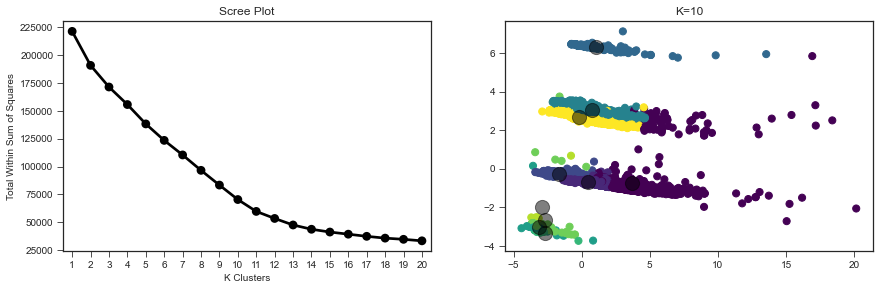

Figure 2. Left shows scree plot of percentage of variances as a function of number of clusters. Right shows clusters in the PCA plot classified by K-Means. 


In [4]:
# Plot SSE for each K
plt.subplot(1, 2, 1)
sns.pointplot(x=list(inertias.keys()), y=list(inertias.values()), color='black')
plt.title("Scree Plot")
plt.xlabel('K Clusters')
plt.ylabel("Total Within Sum of Squares")

# Plot cluster
plt.subplot(1, 2, 2)
plt.scatter(pca_scores[:,0], pca_scores[:,1], 
            c = y_kmeans10, 
            s = 50, 
            cmap = "viridis");
centers10 = kmeans10.cluster_centers_
plt.scatter(centers10[:,0], 
            centers10[:,1], 
            c = 'black', 
            s = 200, alpha = 0.5);
plt.title("K=10");

plt.subplots_adjust(left  = 0.125,   # the left side of the subplots of the figure
                right = 2.0,     # the right side of the subplots of the figure
                bottom = 0.1,    # the bottom of the subplots of the figure
                top = 0.9,       # the top of the subplots of the figure
                wspace = 0.2,    # the amount of width reserved for blank space between subplots
                hspace = 0.2)   # the amount of height reserved for white space between subplots

plt.show()
print("Figure 2. Left shows scree plot of percentage of variances as a function of number of clusters. Right shows clusters in the PCA plot classified by K-Means. ")


##### Label Projection
To better visualize and draw meaning from the clusters, labels were projected onto the pca plot (Figure 3). Neighbourhood labels were for the top 5 neighbourhoods with listings: Beyoglu (4703), Sisli (2618), Kadikoy (1942), Fatih (1563), and Besiktas (1465). Price category labels were for low (1807), medium (6374), and high (4110) pricing. Property type labels were for the top 3 prevalent types: apartments (10426), serviced apartment (1067), and houses (798). Room type labels consisted of entire home/apt (7228), private room (4696), shared room (209), and hotel room (168). 

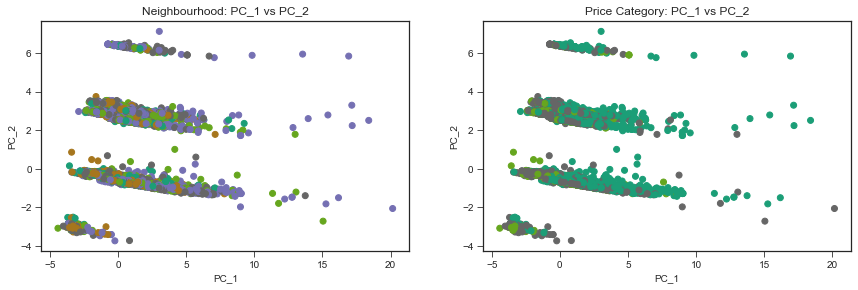

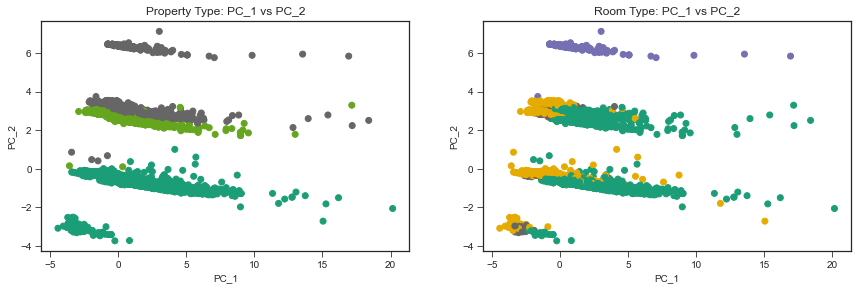

Figure 3. PCA plots with projected labels. Top left is by neighbourhood. Top right is by price (low, medium, high). Bottom left is by property type. Bottom right is by room type. 


In [5]:
# Set Label Encoder
LE = LabelEncoder()

# Plot explained variances - Shows variance drop-off after 4th component
plt.subplot(1, 2, 1)
plt.scatter(pca_scores[:,0], pca_scores[:,1], 
            c = LE.fit_transform(labs_neig["neighbourhood_cleansed"]), 
            cmap = "Dark2"); 
plt.xlabel("PC_1");
plt.ylabel("PC_2");
plt.title("Neighbourhood: PC_1 vs PC_2");

# Plot scores on first versus second PC
plt.subplot(1, 2, 2)
plt.scatter(pca_scores[:,0], pca_scores[:,1], 
            c = LE.fit_transform(labs_price["price_category"]), 
            cmap = "Dark2"); 
plt.xlabel("PC_1");
plt.ylabel("PC_2");
plt.title("Price Category: PC_1 vs PC_2");

plt.subplots_adjust(left  = 0.125,   # the left side of the subplots of the figure
                right = 2.0,     # the right side of the subplots of the figure
                bottom = 0.1,    # the bottom of the subplots of the figure
                top = 0.9,       # the top of the subplots of the figure
                wspace = 0.2,    # the amount of width reserved for blank space between subplots
                hspace = 0.2)   # the amount of height reserved for white space between subplots
plt.show()

# Plot SSE for each K
plt.subplot(1, 2, 1)
plt.scatter(pca_scores[:,0], pca_scores[:,1], 
            c = LE.fit_transform(labs_prop["property_type"]), 
            cmap = "Dark2"); 
plt.xlabel("PC_1");
plt.ylabel("PC_2");
plt.title("Property Type: PC_1 vs PC_2");

# Plot cluster
plt.subplot(1, 2, 2)
plt.scatter(pca_scores[:,0], pca_scores[:,1], 
            c = LE.fit_transform(labs_room["room_type"]), 
            cmap = "Dark2"); 
plt.xlabel("PC_1");
plt.ylabel("PC_2");
plt.title("Room Type: PC_1 vs PC_2");

plt.subplots_adjust(left  = 0.125,   # the left side of the subplots of the figure
                right = 2.0,     # the right side of the subplots of the figure
                bottom = 0.1,    # the bottom of the subplots of the figure
                top = 0.9,       # the top of the subplots of the figure
                wspace = 0.2,    # the amount of width reserved for blank space between subplots
                hspace = 0.2)   # the amount of height reserved for white space between subplots
plt.show()
print("Figure 3. PCA plots with projected labels. Top left is by neighbourhood. Top right is by price (low, medium, high). Bottom left is by property type. Bottom right is by room type. ")


### Discussion
After selecting 18 features for the top five neighbourhoods in the city of Istanbul by the end of December, 2019, listings could be grouped using PCA (Figure 1) and assigned to clusters (Figure 2). Features to generate the plots were chosen based on assummed commonly searched for listing criteria by potential Airbnb guests. When PC 1 and PC 2 were plotted as a scatterplot, four general 'clusters' were visually detected. However, using K-Means Clustering, 10 clusters were formally classified. 

To explore which listings the clusters may correspond to, several different labels were projected onto the PCA plot. When neighbourhoods were projected, there was no clear clustering. Pricing label shows clustering in each of the four general 'clusters', where dark green tends to have positive PC 1 scores, grey tends to have PC 1 scores near zero, and light green tends to have negative PC 1 scores. Property labels clustering tended to be more dependent on PC 2 scores, where high PC 2 scores were labeled in grey and low PC 2 scores labeled in dark green. Room type labels seemed to cluster most similarly to the 10 K-Means defined clusters. 

Taking into account all the projections, the 10 K-Means defined clusters make sense, as there are several types of listings that can be grouped by depending on price, property type, and room type. However, the observation that neighbourhoods do not cluster implies that, at the the top five, neighbourhoods have a variety of listings that potential Airbnb guests can examine. 

Some limitations of this analysis is that the clusters cannot be properly labeled by the type of room, property, or pricing. The next step is to properly label the ten clusters into distinct categories, such as 'high price - apartment - entire home/apt'. Further, it would be helpful to visualize these results on a map of the city opposed to a scatter plot, so guests can filter by location. 


### Conclusion
From this visualization by PCA and K-Means Clustering, it is possible to group the thousands of Airbnb listings by a listing's offerings, type, and pricing. While this analysis was performed on only the top five neighbourhoods with the most listings and only on three property types, it can be extended to be more or less inclusive of both listings and featues included. Future analysis could also group properties based on amenities, reviews, host information, and descriptions. Regardless, further development of this analysis would enable a prospective Airbnb guest to narrow down their listings search to reduce search time. 
